In [239]:
import polars as pl
from typing import Literal

def seasonal_decomposition(
    df: pl.DataFrame,
    id_col: str,
    target_col: str,
    time_col: str,
    freq: int,
    method: Literal['additive', 'multiplicative'] = 'additive'
) -> pl.DataFrame:
    """
    Perform seasonal decomposition of time series data using either an additive or multiplicative method.
    
    Parameters:
    - df: Polars DataFrame containing the time series data.
    - id_col: The column to group by (e.g., for multiple time series).
    - target_col: The column containing the time series values to decompose.
    - time_col: The column containing the time values.
    - freq: The seasonal period (e.g., 12 for monthly data with yearly seasonality).
    - method: The decomposition method ('additive' or 'multiplicative').
    
    ADDITIVE = Y(t) = T(t) + S(t) + E(t) 
    MULTIPLICATIVE = Y(t) = T(t) * S(t) * E(t)
    
    Returns:
    - Polars DataFrame with the decomposed components: trend, seasonal component, and residuals.
    """
    # Add the row index and period index
    df = (df.with_columns(
        pl.col(time_col).cum_count().over(id_col).alias('row_nr')
    )
    .with_columns( # create period idx based on frequency for each unique id 
        pl.col('row_nr').mod(freq).over(id_col).alias('period_idx')
        )
    ) 
    
    # Trend: Rolling mean with window size = freq
    trend_expr = (pl.col(target_col)
                  .rolling_mean(window_size=freq, 
                                center=True)
                  .over(id_col)
                  .alias('trend'))
    
    # Seasonal component (additive method)
    seasonal_component_expr = (pl.col(target_col)
                               .sub(pl.col('trend'))
                               .mean()
                               .over(id_col, 'period_idx')
                               .alias('seasonal_idx'))

    # Adjust seasonal component to have mean = 0 (for additive)
    seasonal_idx_expr = (pl.col('seasonal_idx')
                         .sub(pl.col('seasonal_idx').mean().over(id_col))
                         .alias(f'seasonal_{freq}'))

    # Residuals: Original series - trend - seasonal components (additive)
    residuals_expr = (pl.col(target_col)
                      .sub(pl.col('trend'))
                      .sub(pl.col(f'seasonal_{freq}'))
                      .alias('resid'))

    # Apply decomposition method
    if method == 'additive':
        # For additive decomposition, residuals are the original minus trend and seasonal component
        series = (df
                  .with_columns(trend_expr)
        .with_columns(seasonal_component_expr)

        .with_columns(seasonal_idx_expr)

        .with_columns(residuals_expr)
        
        .select(id_col,time_col,target_col,'trend',f'seasonal_{freq}','resid')

        #drop nulls created by centered moving average 
        .drop_nulls()
    
        )
    elif method == 'multiplicative':
        # For multiplicative decomposition, residuals are the original divided by trend and seasonal component
        seasonal_component_expr = (pl.col(target_col)
                                   .truediv(pl.col('trend'))
                                   .mean()
                                   .over(id_col, 'period_idx')
                                   .alias('seasonal_idx'))

        seasonal_idx_expr = (pl.col('seasonal_idx')
                             .sub(pl.col('seasonal_idx').mean().over(id_col))
                             .alias(f'seasonal_{freq}'))

        residuals_expr = (pl.col(target_col)
                          .truediv(pl.col('trend'))
                          .truediv(pl.col(f'seasonal_{freq}'))
                          .alias('resid'))

        # Apply multiplicative method
        series =  (df
                   .with_columns(trend_expr)
        .with_columns(seasonal_component_expr)

        .with_columns(seasonal_idx_expr)

        .with_columns(residuals_expr)

        .select(id_col,time_col,target_col,'trend',f'seasonal_{freq}','resid')
        
        #drop nulls created by centered moving average 
        .drop_nulls()
        )
    
    return series

In [240]:


df = pl.scan_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv',try_parse_dates=True).collect()

# Call the seasonal_decomposition function
decomposed_df = seasonal_decomposition(
    df,
    id_col='unique_id',    # Group by store
    target_col='y',   # Decompose the sales column
    time_col='ds',      # The time column (in this case, date)
    freq=12,              # specify this as the frequency of your data, so hourly frequency with daily seasonality.... 
    method='additive'     # You can also try 'multiplicative'
)


In [242]:
import polars_ds as pds 
from typing import Literal,List

def fourier_decomposition(df:pl.DataFrame,
                          id_col:str,
                          time_col:str,
                          target_col:str,
                          ts_freq: int, 
                           freqs: List[Literal['week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']] = ['week'],
                          n_fourier_terms: int = 3) -> pl.DataFrame:
    

    """
    Perform Fourier decomposition on a time series dataset to extract trend, seasonal, and residual components.
    The decomposition is based on Fourier harmonics for various temporal frequencies (e.g., week, month, quarter).

    Parameters:
    ----------
    df : pl.DataFrame
        The input Polars DataFrame containing the time series data.

    id_col : str
        The name of the column that uniquely identifies each row (e.g., "id").

    time_col : str
        The name of the column containing the timestamps or time values. This is used to generate temporal features like "week", "month", etc.

    target_col : str
        The name of the target variable (column) whose seasonal and trend components are being decomposed.

    ts_freq: int 
        the number of periods within a seasonal cycle: 52 for weekly data, 4 for quarterly data, 12 for monthly data, etc..... 

    freqs : List[Literal['week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']], optional (default is ['week'])
        A list of frequencies to use for generating Fourier harmonics. Options include:
        - 'week' (weekly frequency)
        - 'month' (monthly frequency)
        - 'quarter' (quarterly frequency)
        - 'day_of_week' (day of the week, 0-6)
        - 'day_of_month' (day of the month, 1-31)
        - 'day_of_year' (day of the year, 1-365/366)

    n_fourier_terms : int, optional (default is 3)
        The number of Fourier terms (harmonics) to generate for each frequency. Higher values allow capturing more complex seasonal patterns.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with the following columns:
        - `id_col`: The original ID column.
        - `time_col`: The original time column.
        - `target_col`: The original target variable.
        - `trend`: The estimated trend component (using moving average).
        - `seasonal`: The seasonal component (estimated using Fourier harmonics).
        - `resid`: The residuals, computed as the difference between the original target and the sum of the trend and seasonal components.
    """

    freq_dict = {'week':pl.col(time_col).dt.week().alias('week'),
                'month':pl.col(time_col).dt.month().alias("month"),
                'quarter':pl.col(time_col).dt.quarter().alias('quarter'),
                'day_of_week':pl.col(time_col).dt.weekday().alias('day_of_week'),
                'day_of_month':pl.col(time_col).dt.day().alias('day_of_month'),
                'day_of_year':pl.col(time_col).dt.ordinal_day().alias('day_of_year')
                }
    

    # Trend: Rolling mean with window size = freq
    trend_expr = (pl.col(target_col)
                  .rolling_mean(window_size= ts_freq,
                                center=True)
                  .over(id_col)
                  .alias('trend'))

    #generate date features for all keys in freq dict 
    date_features = [freq_dict[freq] for freq in freqs]

    #generate harmonic pairs 
    generate_harmonics = [
        [pl.col(freq).mul(i).sin().over(id_col).name.suffix(f'_sin_{i}') for freq in freqs
    ] + [pl.col(freq).mul(i).cos().over(id_col).name.suffix(f'_cos_{i}') for freq in freqs]

    for i in range(1,n_fourier_terms + 1)
    ] 

    #flatten the nested lists into a single list of expressions 
    harmonic_expr = [pair for sublist in generate_harmonics for pair in sublist]

    # add date features and harmonics 
    df = df.with_columns(*date_features).with_columns(*harmonic_expr)

    # these are all the sine/cosine pairs in the data, pds doesn't play nice with polars.selectors :( 
    independent_vars = [col for col in df.columns 
                        if '_cos' in col or '_sin' in col]

    # detrend the series using Moving Averages, fit linear regression with fourier terms as features. 
    result = (df
            
            .with_columns(trend_expr)
    
                .drop_nulls() # drop nulls created by moving average 

                    .with_columns(pl.col(target_col).sub(pl.col('trend')).over(id_col).alias(f'{target_col}_detrend'))

                    #fit linear regression on detrended data
                    .with_columns(pds.lin_reg(*independent_vars,target=target_col + '_detrend',
                                            return_pred=True,
                                            l2_reg=.001).over(id_col).struct.field('pred').alias('seasonal'))

                    .with_columns(pl.col('trend').add(pl.col('seasonal')).sub(pl.col(target_col)).over(id_col).alias('resid'))

                    .select(id_col,time_col,target_col,'trend','seasonal','resid')

    )

    return result 

In [243]:
fourier = fourier_decomposition(df = df,
                      id_col='unique_id',
                      time_col = 'ds',
                      ts_freq=12,
                      target_col='y',
                      freqs = ['month','quarter'],
                      n_fourier_terms=10)

<Axes: xlabel='ds'>

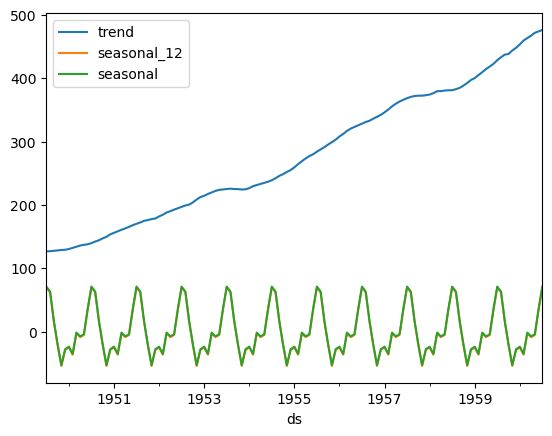

In [244]:
ax = decomposed_df.to_pandas().plot(x='ds',y=['trend','seasonal_12'])

fourier.to_pandas().plot(x='ds',y=['seasonal'],ax=ax)

shape: (5, 3)
┌────────────┬───────────┬───────────┐
│ time       ┆ target    ┆ unique_id │
│ ---        ┆ ---       ┆ ---       │
│ date       ┆ f64       ┆ i32       │
╞════════════╪═══════════╪═══════════╡
│ 2023-01-01 ┆ 53.988769 ┆ 1         │
│ 2023-01-02 ┆ 62.694158 ┆ 1         │
│ 2023-01-03 ┆ 75.646745 ┆ 1         │
│ 2023-01-04 ┆ 85.949582 ┆ 1         │
│ 2023-01-05 ┆ 62.044532 ┆ 1         │
└────────────┴───────────┴───────────┘


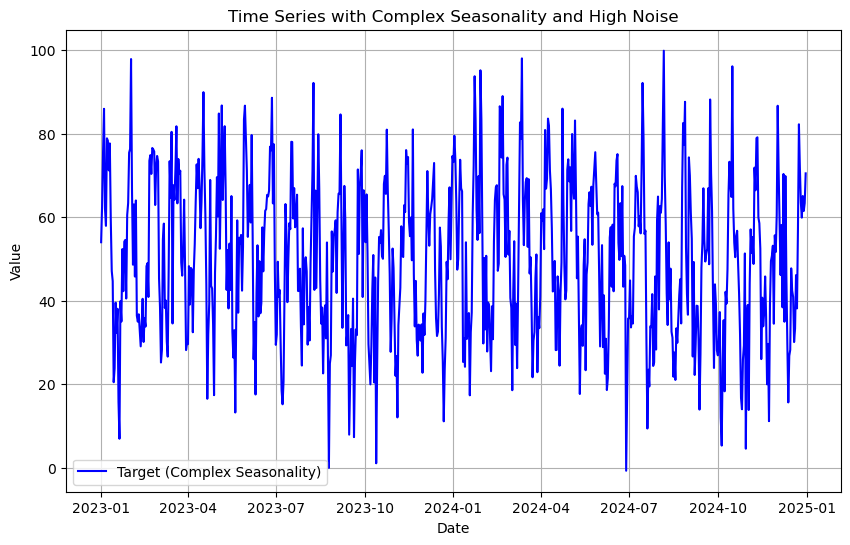

In [264]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate complex seasonality with increased noise
def generate_complex_seasonality(n_samples: int, start_date: str, end_date: str):
    # Generate time index (daily frequency)
    time_index = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Generate time series with multiple seasonal components and noise
    time_in_days = np.arange(n_samples)

    # Daily seasonality (e.g., hourly pattern repeated for each day)
    daily_seasonality = np.sin(2 * np.pi * time_in_days / 24)  # Cycle repeats every 24 units (e.g., 24 hours)
    
    # Weekly seasonality (e.g., day of the week pattern)
    weekly_seasonality = np.sin(2 * np.pi * time_in_days / 7)  # Cycle repeats every 7 days (week)
    
    # Yearly seasonality (e.g., month of the year pattern)
    yearly_seasonality = np.sin(2 * np.pi * time_in_days / 365)  # Cycle repeats every 365 days (year)
    
    # Add more noise: Increase variance and add a periodic random noise component
    noise = np.random.normal(0, 10, n_samples)  # Higher variance for stronger noise
    random_noise = np.random.normal(0, 1, n_samples)  # Smaller noise component
    periodic_noise = 1 * np.sin(2 * np.pi * time_in_days / 10)  # Additional periodic noise
    
    # Combine seasonalities with random and periodic noise (to create complexity)
    target = 50 + 20 * daily_seasonality + 10 * weekly_seasonality + 5 * yearly_seasonality + noise + random_noise + periodic_noise
    
    # Create the dataframe in Polars
    df = pl.DataFrame({
        "time": time_index,
        "target": target
    })
    
    return df

# Generate complex seasonality data (e.g., for 2 years of daily data)
n_samples = 365 * 2 + 1  # 2 years of daily data
start_date = '2023-01-01'
end_date = '2024-12-31'
df = generate_complex_seasonality(n_samples, start_date, end_date)

# Convert time column to Polars Date type and add unique ID
df = df.with_columns(pl.col("time").cast(pl.Date).alias("time"),
                     pl.lit(1).alias('unique_id'))

# Display first few rows
print(df.head())

# Plot the generated time series to visualize the seasonality
plt.figure(figsize=(10, 6))
plt.plot(df["time"].to_pandas(), df["target"].to_pandas(), label="Target (Complex Seasonality)", color='b')
plt.title("Time Series with Complex Seasonality and High Noise")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [265]:
fourier = fourier_decomposition(df = df,
                      id_col = 'unique_id',
                      time_col='time',
                      target_col='target',
                      ts_freq=365,
                      n_fourier_terms = 10,
                      freqs = ['day_of_month','month','week','day_of_year'])


normal = seasonal_decomposition(df=df,
                    id_col = 'unique_id',
                      time_col='time',
                      target_col='target',
                      freq=365)

# Plot against each other to see the different seasonal components... 

* Fourier grows in complexity as you add terms, may filter out some noise. 
* Naive Seasonal will simply gather the period avgs of the detrended series.. 

<Axes: xlabel='time'>

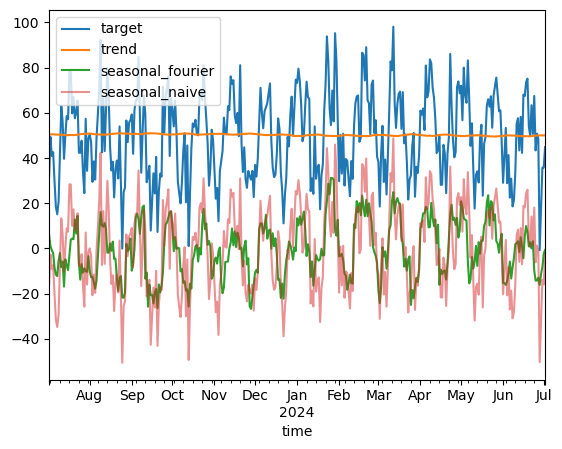

In [268]:
ax = fourier.to_pandas().plot(x='time',y=['target','trend','seasonal'],label = ['target','trend','seasonal_fourier'])

normal.to_pandas().plot(x='time',y=['seasonal_365'],ax=ax,alpha=.5,label=['seasonal_naive'])